<a href="https://colab.research.google.com/github/YSW2/Ajou-Capstone-SOGM/blob/master/portfolio_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import data as web
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm import tqdm
import datetime
import matplotlib as mpl
from scipy.optimize import minimize
import yfinance as yf
yf.pdr_override()

# 학습 데이터 셋 설정

In [37]:
# 학습 데이터셋 기간 설정
start = datetime.datetime(2022, 1, 25)
end = datetime.datetime(2024, 12, 30)

In [38]:
# input_ticker("tickers") 티커 입력하면 리스트형태로 관련 종목나오게 하는 함수

In [39]:
# input tickers
tickers = ['005930.KS', '035420.KS', '033780.KS', '005380.KS', '105560.KS', '017670.KS', 'AAPL', 'TSLA', 'XOM']
num_kr = pd.Series(tickers).str.endswith(".KS").sum()
num_us = (~pd.Series(tickers).str.endswith(".KS")).sum()
adjClose = pd.DataFrame()


for item in tickers:
    data = web.get_data_yahoo(item, start=start, end=end)
    adjClose[item] = data['Adj Close'].round().astype(int)

adjClose.isnull().sum()
# 로그 리턴 계산
daily_log_returns = np.log(adjClose/adjClose.shift(1)).dropna()
# 연간 로그 수익률 계산
meanReturns = daily_log_returns.mean()
annualReturns = daily_log_returns.mean() * 252
# 종목간의 수익률 공분산 계산
cov_daily = daily_log_returns.cov()
cov_annual = cov_daily * 252


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [40]:
num_kr

6

In [41]:
num_us

3

# 기회집합 구성

In [42]:
# 기회집합 구성
p_returns = []
p_volatility = []
p_weights = []

n_assets = len(tickers)
# n_ports = int(input("랜덤하게 만들 포트폴리오 갯수를 입력하세요:"))
n_ports = 40000

for s in tqdm(range(n_ports)):
  wgt = np.random.random(n_assets)
  wgt /= np.sum(wgt)
  ret = np.dot(wgt, annualReturns)
  vol = np.sqrt(np.dot(wgt.T, np.dot(cov_annual, wgt)))
  p_returns.append(ret)
  p_volatility.append(vol)
  p_weights.append(wgt)

100%|██████████| 40000/40000 [00:01<00:00, 22025.82it/s]


<ipython-input-43-cc524dfb291b>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


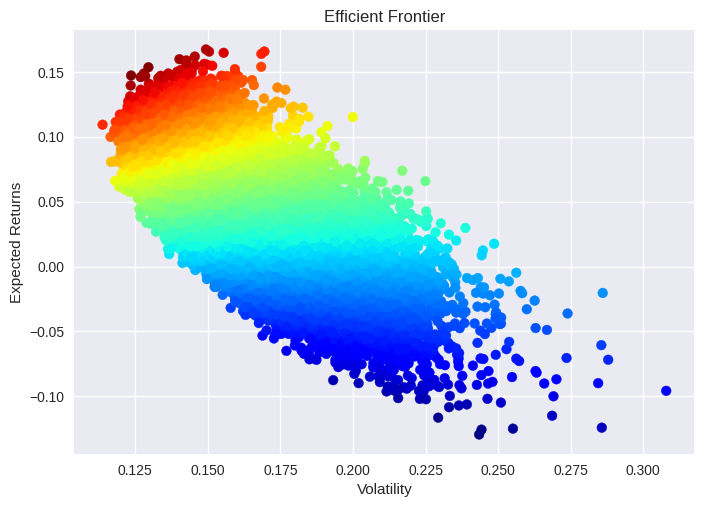

In [43]:
# 기회집합 포트폴리오
p_volatility = np.array(p_volatility)
p_returns = np.array(p_returns)
colors = p_returns/p_volatility
plt.style.use('seaborn')
plt.scatter(p_volatility, p_returns, c=colors, marker='o', cmap=mpl.cm.jet)
plt.xlabel('Volatility')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

# 최소분산 포트폴리오 구성

In [44]:
# 변동성 최적화 목적함수
def obj_variance(weights, covmat):
    vol = np.sqrt(np.dot(weights, np.dot(covmat, weights.T)))
    return vol

In [45]:
# 변동성 계산함수
def cal_variance(weights, covmat):
    vol = np.sqrt(np.dot(weights, np.dot(covmat, weights.T)))
    return vol

In [46]:
# 수익률 계산 함수
def cal_return(weight, annualreturns):
  returns = np.sum(weight * annualreturns)
  return returns

In [47]:
weights = np.ones([n_assets])/n_assets # 초기 비중은 균일하게 시작
bnds = tuple((0., 1.) for i in range(n_assets)) # 종목당 최소 투자비중 : 0%, 최대 투자가능 비중: 100%
cons = ({'type': 'eq', 'fun': lambda w:  np.sum(w) - 1}) # 투자비중의 합이 1이 되게 설정
res = minimize(obj_variance, weights, cov_annual, method='SLSQP', bounds=bnds, constraints=cons)

<ipython-input-48-e8a471bb2208>:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


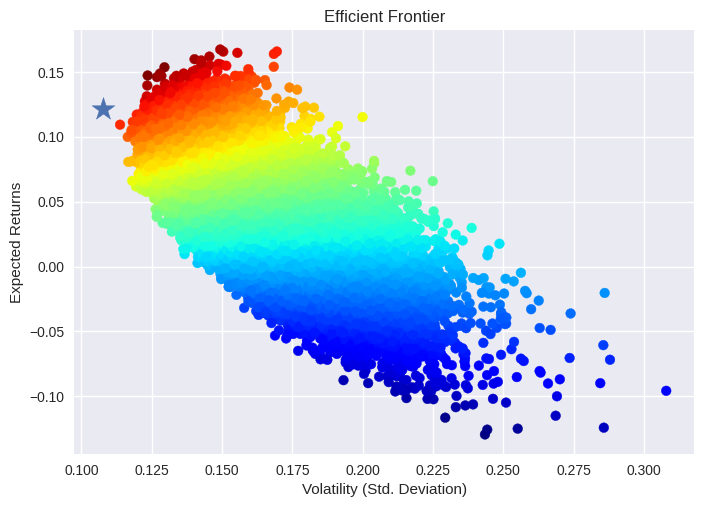

In [48]:
# 최소분산 포트폴리오 시각화
rets = cal_return(res['x'], annualReturns)
vol = cal_variance(res['x'],cov_annual)
p_volatility = np.array(p_volatility)
p_returns = np.array(p_returns)
colors = p_returns/p_volatility
plt.style.use('seaborn')
plt.scatter(p_volatility, p_returns, c=colors, marker='o', cmap=mpl.cm.jet)
plt.scatter(vol, rets, marker="*", s=300, alpha=1.0)
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

In [49]:
print("최적화된 포트폴리오 투자 비중 :", res['x'])
print("최적화된 포트폴리오 투자 수익률 :", cal_return(res['x'], annualReturns))
print("최적화된 포트폴리오 위험정도 :", cal_variance(res['x'],cov_annual))

최적화된 포트폴리오 투자 비중 : [8.49861462e-02 5.58364119e-18 3.92076157e-01 8.26370424e-02
 5.42101086e-20 2.58829663e-01 9.39852130e-02 0.00000000e+00
 8.74857784e-02]
최적화된 포트폴리오 투자 수익률 : 0.12180846277188058
최적화된 포트폴리오 위험정도 : 0.1075309702537767


#Sharpe ratio 최적화

## Sharpe Ratio 최적화방법 1

In [50]:
# shrpe ratio 최적화 함수 설정
def obj_sharpe(weights, returns, covmat, rf):
    ret = np.dot(weights, returns)
    vol = np.sqrt(np.dot(weights.T, np.dot(covmat, weights)))
    return -(ret-rf)/vol

In [51]:
# shrpe ratio 계산 함수
def cal_sharpe(weights, returns, covmat, rf):
    ret = np.dot(weights, returns)
    vol = np.sqrt(np.dot(weights.T, np.dot(covmat, weights)))
    return (ret-rf)/vol

In [52]:
# KOFR = 한국 무위험 수익률 출처:(https://www.kofr.kr/main.jsp)
rf1 = pd.read_csv("/content/drive/MyDrive/NH/data/KOFR.csv")
kor_rf = round((rf1['KOFR'].mean()) / 100 , 4)
kor_rf

0.0349

In [53]:
# SOFR = 미국 무위험 수익률 출처:(https://www.newyorkfed.org/markets/reference-rates/sofr)
rf2 = pd.read_csv("/content/drive/MyDrive/NH/data/SOFR.csv")
us_rf = round((rf2['Rate (%)'].mean()) / 100 , 4)
us_rf

0.0491

In [54]:
# 포트폴리오 무위험 이자율 = 각 자산군별 국가의 무위험 수익률의 가중치
n_assets = len(tickers)
w_kr = num_kr / n_assets
w_us = num_us / n_assets
p_rf = round((w_kr * kor_rf + w_us * us_rf), 4)

In [55]:
p_rf

0.0396

In [56]:
# sharpe ratio 최적화 방법 1 최적화 함수 사용
n_assets = len(tickers)
weights = np.ones([n_assets])/n_assets
bnds = tuple((0, 1.0) for i in range(n_assets))
cons = ({'type': 'eq', 'fun': lambda w:  np.sum(w) - 1})
res = minimize(obj_sharpe, weights,(annualReturns, cov_annual, p_rf), method='SLSQP', bounds=bnds, constraints=cons)

In [57]:
print(res['x'])

[7.07080517e-16 0.00000000e+00 6.02873294e-01 1.43010520e-01
 8.35726228e-03 6.97966120e-16 6.70245599e-16 7.56597969e-16
 2.45758924e-01]


In [58]:
# n번개의 랜덤한 비중을 가지는 포트폴리오 구성
p_returns = []
p_volatility = []
p_weights = []

n_assets = len(tickers)
# n_ports = int(input("랜덤하게 만들 포트폴리오 갯수를 입력하세요:"))
n_ports = 50000

for s in tqdm(range(n_ports)):
  wgt = np.random.random(n_assets)
  wgt /= np.sum(wgt)
  ret = np.dot(wgt, annualReturns)
  vol = np.sqrt(np.dot(wgt.T, np.dot(cov_annual, wgt)))
  p_returns.append(ret)
  p_volatility.append(vol)
  p_weights.append(wgt)

100%|██████████| 50000/50000 [00:02<00:00, 24314.59it/s]


<ipython-input-59-cdfebcb1e1d7>:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


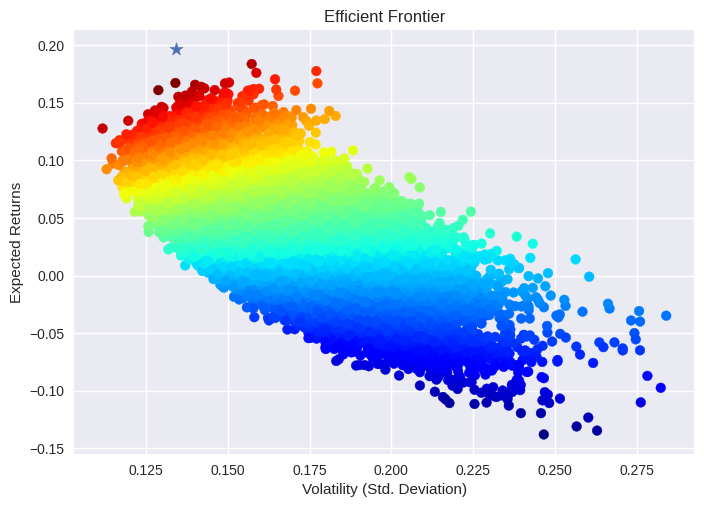

In [59]:
# 포트폴리오 시각화
rets = cal_return(res['x'], annualReturns)
vol = cal_variance(res['x'],cov_annual)
p_volatility = np.array(p_volatility)
p_returns = np.array(p_returns)
colors = p_returns/p_volatility
plt.style.use('seaborn')
plt.scatter(p_volatility, p_returns, c=colors, marker='o', cmap=mpl.cm.jet)
plt.scatter(vol, rets, marker="*", s=100, alpha=1.0)
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

In [60]:
print("최적화된 포트폴리오 투자 비중(%) :", [round(element * 100,2) for element in res['x']])
print("최적화된 포트폴리오 투자 수익률 :", cal_return(res['x'], annualReturns))
print("최적화된 포트폴리오 위험정도 :", cal_variance(res['x'],cov_annual))
print("최적화된 포트폴리오 샤프지수정도 :", cal_sharpe(res['x'], annualReturns, cov_annual, p_rf))
# 특정 주식에 비중이 몰려있고 일부 주식은 투자를 안하는 경우가 있다.

최적화된 포트폴리오 투자 비중(%) : [0.0, 0.0, 60.29, 14.3, 0.84, 0.0, 0.0, 0.0, 24.58]
최적화된 포트폴리오 투자 수익률 : 0.1961948547528039
최적화된 포트폴리오 위험정도 : 0.1340452890761077
최적화된 포트폴리오 샤프지수정도 : 1.168223485003588


## Sharpe Ratio 최적화방법 2

In [61]:
# 랜덤비중 구성 포트폴리오 중 선택
p_returns = []
p_volatility = []
p_weights = []
p_sharp = []
n_assets = len(tickers)
# n_ports = int(input("랜덤하게 만들 포트폴리오 갯수를 입력하세요:"))
n_ports = 40000

for s in tqdm(range(n_ports)):
  wgt = np.random.random(n_assets)
  wgt /= np.sum(wgt)
  ret = np.dot(wgt, annualReturns)
  vol = np.sqrt(np.dot(wgt.T, np.dot(cov_annual, wgt)))
  sharp = (ret-p_rf)/vol
  p_returns.append(ret)
  p_volatility.append(vol)
  p_weights.append(wgt)
  p_sharp.append(sharp)

port = pd.DataFrame({
    'Returns': p_returns,
    'Volatility': p_volatility,
    'Weights': p_weights,
    'Sharpe Ratio': p_sharp
})
max_sharpe = port[port['Sharpe Ratio'] == port['Sharpe Ratio'].max()]
rets = max_sharpe['Returns'].iloc[0]
vol = max_sharpe['Volatility'].iloc[0]

100%|██████████| 40000/40000 [00:01<00:00, 22044.46it/s]


<ipython-input-62-78568b667816>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


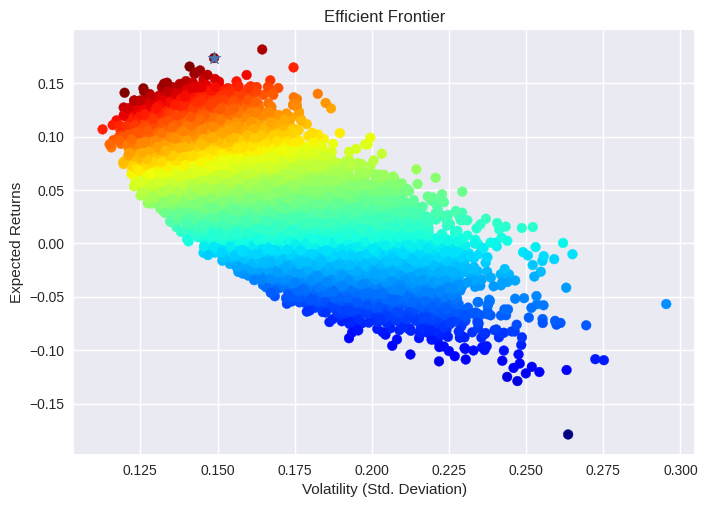

In [62]:
# 시각화
p_volatility = np.array(p_volatility)
p_returns = np.array(p_returns)
colors = p_returns/p_volatility
plt.style.use('seaborn')
plt.scatter(p_volatility, p_returns, c=colors, marker='o', cmap=mpl.cm.jet)
plt.scatter(vol, rets, marker="*", s=100, alpha=1.0)
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

In [63]:
weights = np.array(max_sharpe['Weights'].iloc[0])
rounded_weights = [round(element * 100, 2) for element in weights]
print("최적화된 포트폴리오 투자 비중(%) :", rounded_weights)
print("최적화된 포트폴리오 투자 수익률 :", round(max_sharpe['Returns'].iloc[0],2))
print("최적화된 포트폴리오 무위험 수익 대비 수익률 :", round(max_sharpe['Returns'].iloc[0] - p_rf,2))
print("최적화된 포트폴리오 위험정도 :", round(max_sharpe['Volatility'].iloc[0],2))
print("최적화된 포트폴리오 샤프지수정도 :", (rets-p_rf)/vol)
# 여전히 특정 주식에 대한 비중이 낮다

최적화된 포트폴리오 투자 비중(%) : [2.21, 0.88, 27.11, 6.07, 25.43, 3.26, 8.1, 0.52, 26.42]
최적화된 포트폴리오 투자 수익률 : 0.17
최적화된 포트폴리오 무위험 수익 대비 수익률 : 0.13
최적화된 포트폴리오 위험정도 : 0.15
최적화된 포트폴리오 샤프지수정도 : 0.8997378368749102


# risk-parity (포트폴리오 종목들의 위험기여도가 동일하게 구성)

In [64]:
# 리스크 기여도 계산
def cal_risk_contribution(w, covmat):
    w = np.matrix(w)
    sigma = cal_variance(w, covmat)
    MRC = np.dot(covmat, w.T)
    RC = np.multiply(MRC, w.T) / sigma
    return RC

In [65]:
def risk_budget_objective(weights, covmat):
    # 포트폴리오 위험계산
    sig_p = obj_variance(weights, covmat)
    # 자산별 위험목표 설정
    risk_target = np.multiply(sig_p, weights)
    # 자산 위험도 계산
    asset_RC = cal_risk_contribution(weights, covmat)
    # 목적함수 평가: 자산 위험 기여금과 각각의 위험 목표 간의 차이의 제곱합
    result = sum(np.square(asset_RC - risk_target.T))[0, 0]
    return result

In [66]:
n_assets = len(tickers)
weights = np.ones([n_assets]) / n_assets
bnds = tuple((0, 1.0) for i in range(n_assets))
cons = ({'type': 'eq', 'fun': lambda w:  np.sum(w) - 1})
options = {'maxiter': 1000}
res = minimize(risk_budget_objective, weights, cov_annual, method='SLSQP', bounds=bnds, constraints=cons, options = options)

In [67]:
res['x']

array([0.11006816, 0.06839235, 0.18701633, 0.10616693, 0.08146523,
       0.18145981, 0.09936922, 0.05054614, 0.11551584])

In [68]:
# n번개의 랜덤한 비중을 가지는 포트폴리오 구성
p_returns = []
p_volatility = []
p_weights = []

n_assets = len(tickers)
# n_ports = int(input("랜덤하게 만들 포트폴리오 갯수를 입력하세요:"))
n_ports = 40000

for s in tqdm(range(n_ports)):
  wgt = np.random.random(n_assets)
  wgt /= np.sum(wgt)
  ret = np.dot(wgt, annualReturns)
  vol = np.sqrt(np.dot(wgt.T, np.dot(cov_annual, wgt)))
  p_returns.append(ret)
  p_volatility.append(vol)
  p_weights.append(wgt)

100%|██████████| 40000/40000 [00:01<00:00, 22074.24it/s]


<ipython-input-69-84174b9da81e>:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


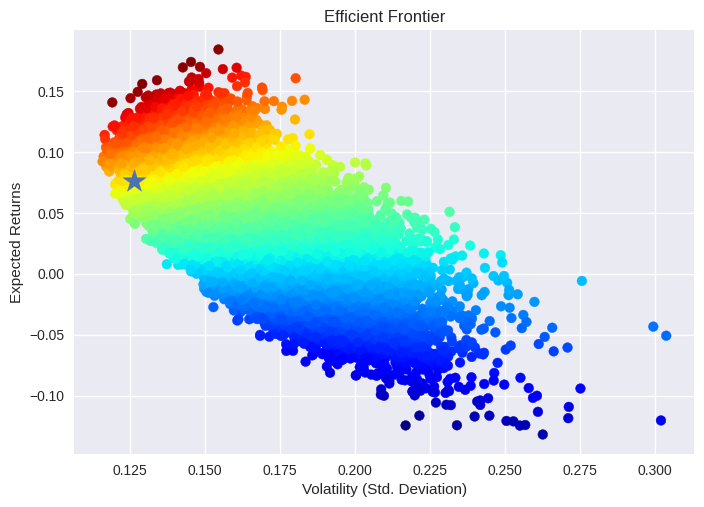

In [69]:
rets = cal_return(res['x'], annualReturns)
vol = cal_variance(res['x'], cov_annual)
sharp = (rets-kor_rf)/vol
p_volatility = np.array(p_volatility)
p_returns = np.array(p_returns)
colors = p_returns/p_volatility
plt.style.use('seaborn')
plt.scatter(p_volatility, p_returns, c=colors, marker='o', cmap=mpl.cm.jet)
plt.scatter(vol, rets, marker="*", s=300, alpha=1.0)
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

<ipython-input-70-f6dfa3d5fd1f>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  risk_contributions_list = [round(float(item), 5) for item in risk_contributions]


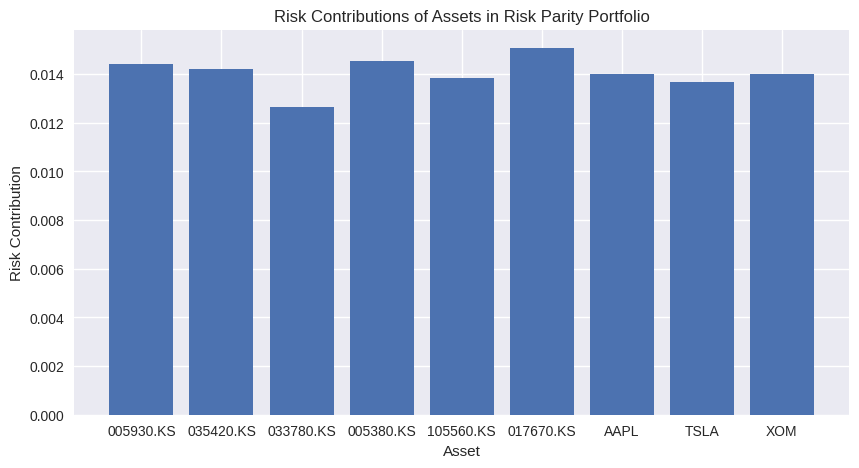

In [70]:
# 자산별 리스크 기여도 시각화
risk_contributions = cal_risk_contribution(res['x'], cov_annual)
risk_contributions_list = [round(float(item), 5) for item in risk_contributions]

plt.figure(figsize=(10, 5))
plt.bar(range(len(risk_contributions_list)), risk_contributions_list,tick_label = adjClose.columns, align='center')
plt.xlabel('Asset')
plt.ylabel('Risk Contribution')
plt.title('Risk Contributions of Assets in Risk Parity Portfolio')
plt.show()

In [71]:
print("최적화된 포트폴리오 투자 비중(%) :", [round(element * 100,2) for element in res['x']])
print("최적화된 포트폴리오 투자 수익률 :" + str(round(cal_return(res['x'], annualReturns) * 100, 2)) + "%")
print("최적화된 포트폴리오 위험정도 :", cal_variance(res['x'],cov_annual))
print("최적화된 포트폴리오 샤프지수정도 :", cal_sharpe(res['x'], annualReturns, cov_annual, p_rf))
print("최적화된 포트폴리오 자산별 리스크 기여도정도 :", risk_contributions_list)
# 비록 샤프비율 최적화에 비해 투자 비중이 낮게 나오지만 포트폴리오 투자 비중이 극단적이지 않음으로 포트폴리오 구성 목적에 더 적합하다고 생각한다.

최적화된 포트폴리오 투자 비중(%) : [11.01, 6.84, 18.7, 10.62, 8.15, 18.15, 9.94, 5.05, 11.55]
최적화된 포트폴리오 투자 수익률 :7.59%
최적화된 포트폴리오 위험정도 : 0.12635207007781724
최적화된 포트폴리오 샤프지수정도 : 0.2871824281979177
최적화된 포트폴리오 자산별 리스크 기여도정도 : [0.01443, 0.01419, 0.01263, 0.01455, 0.01383, 0.01507, 0.01399, 0.01367, 0.014]
